# Assignment
In this part, I change beta into 0.005 and discount factor to 0.4, the same seed as before!

In [1]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
import random

random.seed(2077) 
size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [2]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

In [3]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    #print('a', allowed_a)
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[0 0 0 0]
 [0 3 0 1]
 [0 0 0 2]
 [0 0 0 0]]
check?  0
dofk2  2

[[0 0 0 0]
 [3 0 0 1]
 [0 0 2 0]
 [0 0 0 0]]
0  0
check?  0
dofk2  1

[[0 3 0 0]
 [0 0 0 0]
 [0 0 2 1]
 [0 0 0 0]]
0  0
check?  0
dofk2  1

[[3 0 0 0]
 [0 0 2 0]
 [0 0 0 1]
 [0 0 0 0]]
0  0
check?  0
dofk2  0

[[0 0 0 2]
 [0 3 0 0]
 [0 0 0 1]
 [0 0 0 0]]
0  0
check?  0
dofk2  2

[[0 0 0 0]
 [0 0 0 2]
 [0 3 0 1]
 [0 0 0 0]]
0  0
check?  0
dofk2  2


In [4]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 

S,X,allowed_a=env.Initialise_game()
N_episodes=1000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]

        S,X,allowed_a,R,Done=env.OneStep(a_agent)
        
        
        if Done:
            
            R_save_random[n]=np.copy(R)
            N_moves_save_random[n]=np.copy(i)

            break

        i=i+1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))



Random_Agent, Average reward: 0.206 Number of steps:  7.349


In [5]:
## ADAM code from previous lab

class Adam:

    def __init__(self, Params, beta1):
        
        N_dim=np.shape(np.shape(Params))[0] # It finds out if the parameters given are in a vector (N_dim=1) or a matrix (N_dim=2)
        
        # INITIALISATION OF THE MOMENTUMS
        if N_dim==1:
               
            self.N1=np.shape(Params)[0]
            
            self.mt=np.zeros([self.N1])
            self.vt=np.zeros([self.N1])
        
        if N_dim==2:
            
            self.N1=np.shape(Params)[0]
            self.N2=np.shape(Params)[1]
        
            self.mt=np.zeros([self.N1,self.N2])
            self.vt=np.zeros([self.N1,self.N2])
        
        # HYPERPARAMETERS OF ADAM
        self.beta1=beta1
        self.beta2=0.999
        
        self.epsilon=10**(-8)
        
        # COUNTER OF THE TRAINING PROCESS
        self.counter=0
        
        
    def Compute(self,Grads):
                
        self.counter=self.counter+1
        
        self.mt=self.beta1*self.mt+(1-self.beta1)*Grads
        
        self.vt=self.beta2*self.vt+(1-self.beta2)*Grads**2
        
        mt_n=self.mt/(1-self.beta1**self.counter)
        vt_n=self.vt/(1-self.beta2**self.counter)
        
        New_grads=mt_n/(np.sqrt(vt_n)+self.epsilon)
        
        return New_grads


In [6]:
# policy reference from previous lab
def EpsilonGreedy_Policy(Qvalues, epsilon, allowed_a):
    
    N_a=np.shape(Qvalues)[0]

    rand_value=np.random.uniform(0,1)

    rand_a=rand_value<epsilon

    if rand_a==True:
        # there is the probability of epsilon to choose a random allowed action
        a = np.random.choice(np.where(allowed_a == [1])[0])
        #print('choose a random a from',np.where(allowed_a == [1])[0],a)
    else:
        #return the allowed action with highest Qvalue
        a=np.argmax(Qvalues * allowed_a.T)
            
    return a

In [7]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 


S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES
beta1=0.9               # First order momentum for Adam

## INITALISE YOUR NEURAL NETWORK...
W1 = np.random.randn(N_in, N_h)/np.sqrt(N_in)
W2 = np.random.randn(N_h, N_a)/np.sqrt(N_h)
b1 = np.zeros([1, N_h])
b2 = np.zeros([1, N_a])
#using ADAM as the optimizer
AdamW1 = Adam(W1, beta1)
AdamW2 = Adam(W2, beta1)
Adamb1 = Adam(b1, beta1)
Adamb2 = Adam(b2, beta1)


# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.0005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.4        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE


N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])


In [8]:
# TRAINING LOOP BONE STRUCTURE... SARSA

for n in range(N_episodes):
    
    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    #print(n)                                 ## REMOVE THIS OF COURSE, WE USED THIS TO CHECK THAT IT WAS RUNNING
    
    PIPPO = 0
    
    while Done==0:                           ## START THE EPISODE
        
        if PIPPO:
            Qvalue = Qvalue_next
            a = a_next
        else:
            x0 = X
            h1 = np.dot(x0, W1) + b1
            x1 = 1 / (1 + np.exp(-h1))
            h2 = np.dot(x1, W2) + b2
            Qvalue = 1 / (1 + np.exp(-h2)) # aka x2
            a = EpsilonGreedy_Policy(Qvalue, epsilon_f, allowed_a) 
        #print(n,np.where(allowed_a==1),a_agent) for test only
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a)
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            
            # calculate delta
            delta = np.zeros(b2.shape)
            delta[0][a] = R - Qvalue[0][a] 
            
            delta_W2 = np.matmul(np.transpose(x1),delta)
            delta_b2 = np.expand_dims(np.sum(delta,0),0)  
            #Qvalue[0][a] = Qvalue[0][a] + eta*delta
            
            delta2 = x1 * (1 - x1) * np.dot(delta, W2.T) 
            
            delta_W1 = np.matmul(np.transpose(x0).reshape(-1,1),delta2)
            delta_b1 = np.expand_dims(np.sum(delta2,0),0) 
            
            #update parameters with adam
            W2=W2+eta*AdamW2.Compute(delta_W2)
            b2=b2+eta*Adamb2.Compute(delta_b2)
            W1=W1+eta*AdamW1.Compute(delta_W1)
            b1=b1+eta*Adamb1.Compute(delta_b1)
            
            
            #saving reward and number of moves
            R_save[n] = R
            N_moves_save[n] = i


            break
        
        
        
        
        # IF THE EPISODE IS NOT OVER...
        else:
            
            ## if not end
            # Compute the delta
            x0_next = X_next
            h1_next = np.dot(x0_next, W1) + b1
            x1_next = 1 / (1 + np.exp(-h1_next))
            h2_next = np.dot(x1_next, W2) + b2
            Qvalue_next = 1 / (1 + np.exp(-h2_next))
            a_next = EpsilonGreedy_Policy(Qvalue_next, epsilon_f, allowed_a_next)
            delta = np.zeros(b2.shape)
            delta[0][a] = R - Qvalue[0][a] + gamma * Qvalue_next[0][a_next] #update delta wrt qvalue and current action
            
            
            delta_W2 = np.matmul(np.transpose(x1),delta)
            delta_b2 = np.expand_dims(np.sum(delta,0),0)  
            #Qvalue[0][a] = Qvalue[0][a] + eta*delta
            
            delta2 = x1 * (1 - x1) * np.dot(delta, W2.T) 
            
            delta_W1 = np.matmul(np.transpose(x0).reshape(-1,1),delta2)
            delta_b1 = np.expand_dims(np.sum(delta2,0),0) 
            #updates parameters with adam
            W2=W2+eta*AdamW2.Compute(delta_W2)
            b2=b2+eta*Adamb2.Compute(delta_b2)
            W1=W1+eta*AdamW1.Compute(delta_W1)
            b1=b1+eta*Adamb1.Compute(delta_b1)
            # Update the Qvalues
            #Qtable[a,ind_x,ind_v]=Qtable[a,ind_x,ind_v]+eta*delta

            
            PIPPO=1 #for sarsa only
            
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
        
        
        
    
    

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

Text(0.5, 1.0, 'Average reward per epoch')

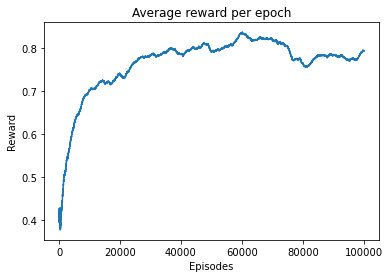

In [14]:
R_save_df = pd.DataFrame(R_save)
Rewm = R_save_df.ewm(span = 10000).mean()
plt.plot(Rewm[100:])

plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Average reward per epoch')

Text(0.5, 1.0, 'Average moves per epoch')

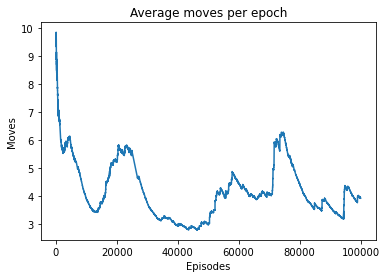

In [15]:
N_moves_save_df = pd.DataFrame(N_moves_save)
Nmewm = N_moves_save_df.ewm(span = 10000).mean()
plt.plot(Nmewm[100:])
plt.xlabel('Episodes')
plt.ylabel('Moves')
plt.title('Average moves per epoch')